In [21]:
import pandas as pd

# First, we define a dataframe of closing prices of SPY and DIA
SPY = pd.read_csv('SPY.csv')
SPY.set_index('Date', inplace=True)
SPY_prices = SPY[['Close']]

DIA = pd.read_csv('DIA.csv')
DIA.set_index('Date', inplace=True)
DIA_prices = DIA[['Close']]
prices = pd.concat([SPY_prices, DIA_prices], axis=1)
prices.columns = ['SPY', 'DIA']
prices.head()

,SPY,DIA
Date,,
2007-01-03,141.369995,124.470001
2007-01-04,141.669998,124.680000
2007-01-05,140.539993,123.739998
2007-01-08,141.190002,124.139999
2007-01-09,141.070007,124.070000


In [36]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [221]:
p1 = prices.iloc[:100] # Initial prices for calculating the initial beta
p2 = prices.iloc[100:]

linreg = LinearRegression()
X = p1[['SPY']]
y = p1[['DIA']]
linreg.fit(X, y)
beta = linreg.coef_

Here, we record the betas as they get updated using the Kalman Filter. The Kalman gain is calculated for every iteration and the newly calculated beta is added to the beta recorder. We also record the rolling regression betas. Finally a dataframe of the beta recorders is created and plotted. It is apparent that the betas of the rolling regression are smoother, while the betas of the Kalman Filter are more reactive.

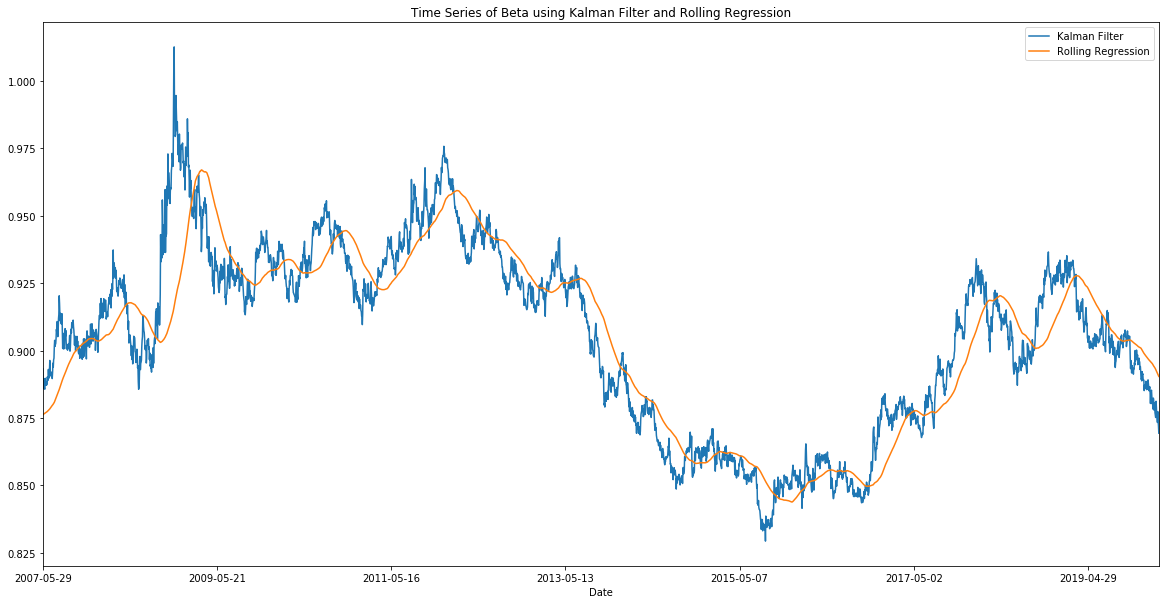

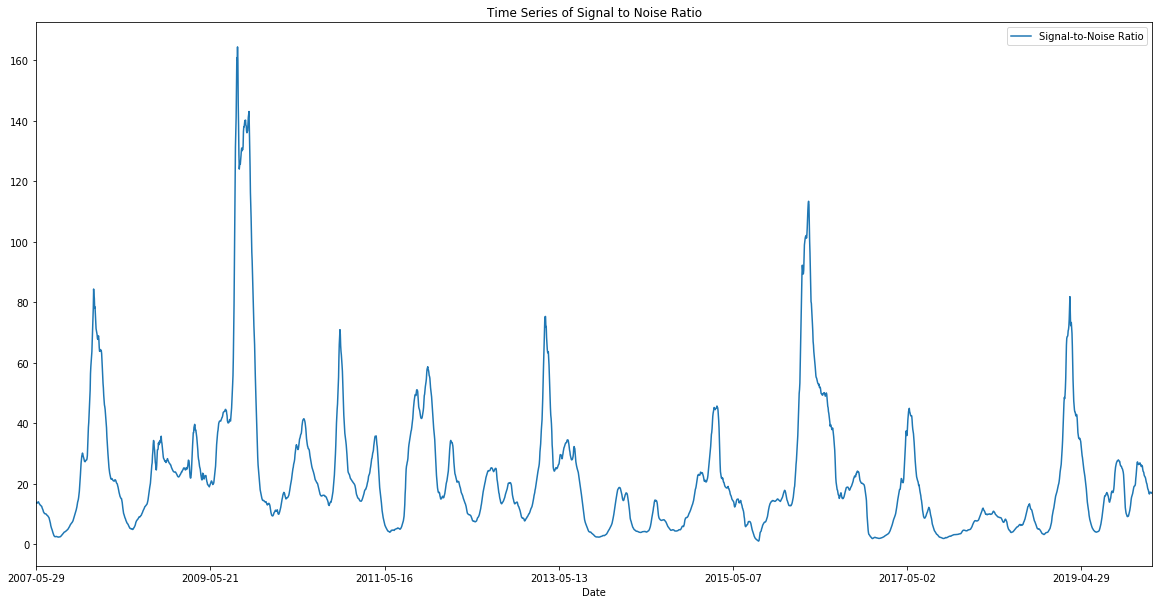

In [229]:
beta_recorder = [float(beta)]
beta_recorder_roll = [float(beta)]
snr_recorder = []
for i in range(len(p2)):
    linreg_back = LinearRegression(fit_intercept=False)
    X_t = p2.iloc[i, 0]
    y_t = p2.iloc[i, 1]
    X_back = prices[['SPY']].iloc[i:i+100]
    y_back = prices[['DIA']].iloc[i:i+100]
    linreg_back.fit(X_back, y_back)
    y_ = pd.DataFrame(linreg_back.predict(X_back), index=y_back.index, columns=y_back.columns)
    beta_roll = float(linreg_back.coef_)
    error = y_back - y_
    var_s = float(y_.var())
    var_v = float(error.var())
    snr = var_s/var_v
    snr_recorder.append(snr)
    kalman_gain = (X_t / ((y_t * y_t) + (1 / snr)))
    beta_update = float(beta + kalman_gain * (y_t - beta * X_t))
    beta = beta_update
    beta_recorder.append(beta)
    beta_recorder_roll.append(beta_roll)

betas_kalman = pd.DataFrame(beta_recorder[1:], index=p2.index, columns=['Kalman Filter'])
betas_roll = pd.DataFrame(beta_recorder_roll[1:], index=p2.index, columns=['Rolling Regression'])
snr_df = pd.DataFrame(snr_recorder, index=p2.index, columns=['Signal-to-Noise Ratio'])
betas = pd.concat([betas_kalman, betas_roll], axis=1)
betas.plot(figsize=(20, 10), title='Time Series of Beta using Kalman Filter and Rolling Regression')
snr_df.plot(figsize=(20, 10), title='Time Series of Signal to Noise Ratio')

Now, we iterate through the dataframe of the values of SPY and DIA to calculate the values of the residual throughout that time. To do this, we take the beta calculated using the Kalman gain and the closing prices of SPY & DIA on the previous day, and use it to calculate the residual of the current day. This residual is appended to the residual recorder called pairs_prices. Then, a dataframe of the residuals is created. We also do the same for the rolling regression.

Finally, we plot the values of the residuals in both cases. The values in case of the Kalman Filter look more stationary than those in case of the rolling regression.

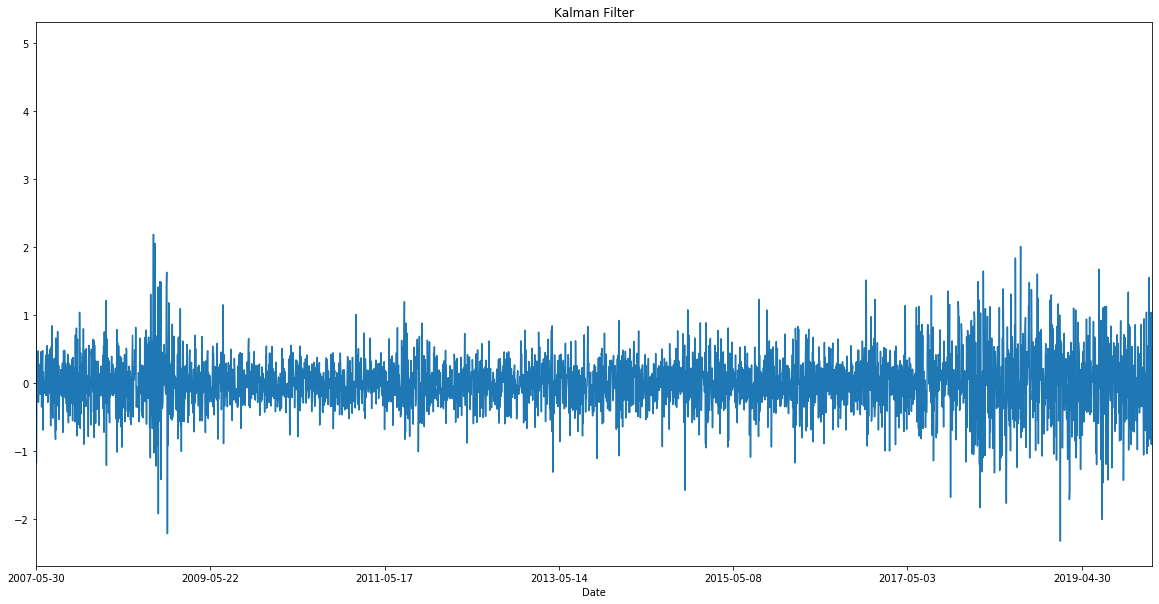

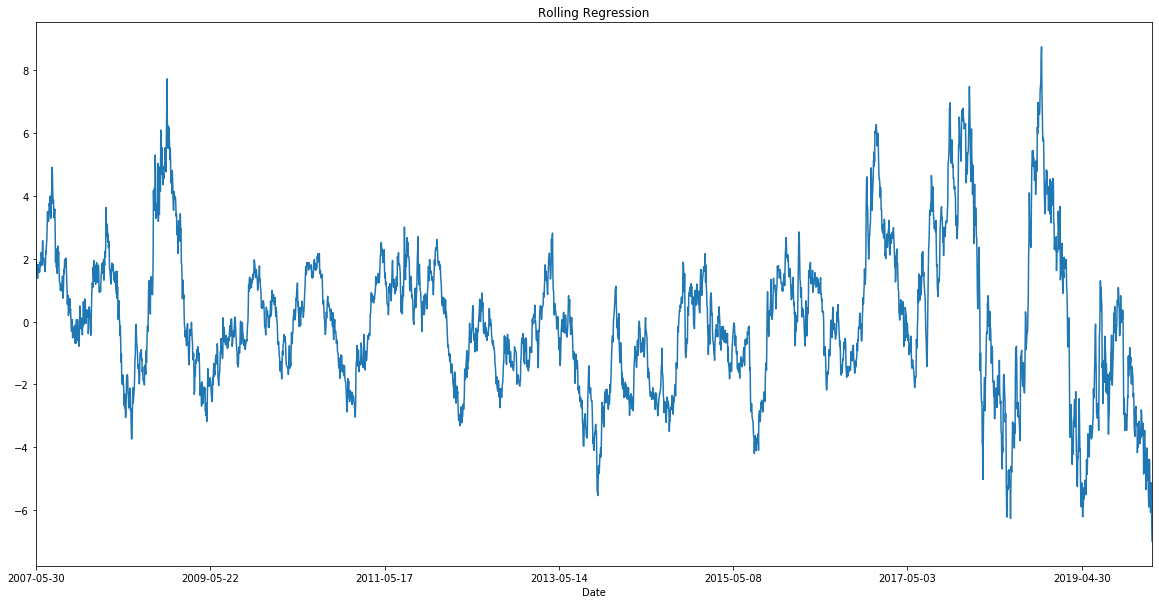

In [223]:
from datetime import datetime, timedelta
pairs_kalman = []
pairs_rolling = []
trading_prices = prices.loc[betas.index[1]:]
beta_multiplier = betas.iloc[0:-1]
beta_multiplier.index = trading_prices.index # Setting the dates of the betas to those of trading prices to ease calculation
for index, rows in trading_prices.iterrows():
    spy_price = rows[0]
    dia_price = rows[1]
    previous_beta_kalman = float((beta_multiplier.loc[index])[['Kalman Filter']])
    previous_beta_rolling = float((beta_multiplier.loc[index])[['Rolling Regression']])
    kalman_price = dia_price - previous_beta_kalman*spy_price
    rolling_price = dia_price - previous_beta_rolling*spy_price
    pairs_kalman.append(kalman_price)
    pairs_rolling.append(rolling_price)

pairs_kalman_df = pd.DataFrame(pairs_kalman, index=trading_prices.index, columns=['Kalman Filter'])
pairs_rolling_df = pd.DataFrame(pairs_rolling, index=trading_prices.index, columns=['Rolling Regression'])
pairs_kalman_df.plot(figsize=(20, 10), title='Kalman Filter', legend=False)
pairs_rolling_df.plot(figsize=(20, 10), title='Rolling Regression', legend=False)

Next, the uncertainties, or volatilities, are calculated. We take the 30 day rolling volatilities for the purpose of our strategy. Then, we define dataframes of the residuals for the days on which the volatilities are calculated. The trading rule will use these dataframes to decide the trading signal.

In [224]:
sd_kalman = (pairs_kalman_df.rolling(30).std()).dropna() # DataFrame of 30 day rolling standard deviations / volatilities
residuals_kalman = pairs_kalman_df.loc[sd_kalman.index]  # DataFrame of residuals starting from day of recording volatilities

sd_rolling = (pairs_rolling_df.rolling(30).std()).dropna() # DataFrame of 30 day rolling standard deviations / volatilities
residuals_rolling = pairs_rolling_df.loc[sd_rolling.index] # DataFrame of residuals starting from day of recording volatilities

Next, we define a class called trade_recorder, that checks the price of the index, and decides whether to buy or sell. It also records the P/L for every buy-sell and sell-buy transaction. The check() method checks if there is an open buy position, open sell position, or neither. In each case, it checks whether the price has breached the boundaries set by the trading rule, and takes the appropriate position. For example, if there is an open buy position, and the upper band has been breached, then the check() method invokes the buy_close() method to close the buy position, the sell_open() method to open a sell position, update_state() method to update the state from an open buy position to an open sell position, records the holding period and P/L of the just-closed buy position, and finally, starts counting the holding period and P/L for the newly opened sell position. Similar actions are taken for all other situations. The position() method returns the current position of the total P/L of the pairs strategy. The position_series returns the time series of the P/L of the pairs strategy.

In [225]:
class trade_recorder():
    def __init__(self, total_buy=0, total_sell=0, state=0):
        self.total_buy = total_buy                          # Records the cumulative P/L from buy-sell transactions
        self.total_sell = total_sell                        # Records the cumulative P/L from sell-buy transactions
        self.state = state                                  # State is 1 for an open buy position, -1 for sell, 0 for none
        self.positions = []                                 # Records the time series of total cumulative P/L
        self.buy_index_start = 0                            # Index when a buy transaction is opened
        self.buy_index_end = 0                              # Index when a buy transaction is closed
        self.buy_timer = []                                 # Records time series of holding times for buy-sell transactions
        self.sell_index_start = 0                           # Index when a sell transaction is opened
        self.sell_index_end = 0                             # Index when a sell transaction is closed
        self.sell_timer = []                                # Records time series of holding times for sell-buy transactions
        self.buy_pnl_start = 0
        self.buy_pnl_end = 0
        self.buy_pnl_counter = []
        self.sell_pnl_start = 0
        self.sell_pnl_end = 0
        self.sell_pnl_counter = []
        
    def buy_open(self, price):
        self.total_buy += -price
        self.buy_pnl_start = price
    
    def buy_close(self, price):
        self.total_buy += price
        self.buy_pnl_end = price
        self.buy_pnl_counter.append((self.buy_pnl_end - self.buy_pnl_start)/self.buy_pnl_start)
    
    def sell_open(self, price):
        self.total_sell += price
        self.sell_pnl_start = price
    
    def sell_close(self, price):
        self.total_sell += -price
        self.sell_pnl_end = price
        self.sell_pnl_counter.append((self.sell_pnl_start - self.sell_pnl_end)/self.sell_pnl_start)
        
    def update_state(self, x):
        self.state = x
    
    def check(self, price, upper_band, lower_band):
        
        if self.state == 0:
            
            if price >= upper_band:
                self.sell_open(price)
                self.update_state(-1)
            
            elif price <= lower_band:
                self.buy_open(price)
                self.update_state(1)
            
            else:
                pass
        
        elif self.state == 1:
            
            if price >= upper_band:
                self.buy_close(price)
                self.sell_open(price)
                self.update_state(-1)
            
            elif price <= lower_band:
                pass
            
            else:
                pass
        
        elif self.state == -1:
            
            if price >= upper_band:
                pass
            
            elif price <= lower_band:
                self.sell_close(price)
                self.buy_open(price)
                self.update_state(1)
                
        self.positions.append(self.position(price))
    
    def end_trade(self, price, index):
        if self.state == 1:
            self.buy_close(price)
            self.update_state(0)
        elif self.state == -1:
            self.sell_close(price)
            self.update_state(0)
    
    def position(self, price):
        if self.state == 0:
            return (self.total_buy + self.total_sell)
        elif self.state == 1:
            return (self.total_buy + price + self.total_sell)
        elif self.state == -1:
            return (self.total_buy + self.total_sell - price)
    
    def position_series(self):
        series_positions = pd.DataFrame(self.positions)
        series_positions.index = range(1, len(self.positions)+1)
        return series_positions


def trade(data, deviation, k):
    recorder = trade_recorder()
    df = data.dropna()
    for index, rows in df.iterrows():
        price = rows[0]
        upper_band = k * float(deviation.loc[index])
        lower_band = -k * float(deviation.loc[index])
        recorder.check(price, upper_band, lower_band)
    last_price = df.iloc[-1, 0]
    last_index = df.index[-1]
    recorder.end_trade(last_price, last_index)
    performance = recorder.position_series()
    performance.columns = ['Portfolio Value']
    return recorder.position(last_price), performance.dropna()

We now use the trade() method to execute the trades and check the evolution of the portfolio under three different conditions:
k = 0.5, k = 1, k = 2. We then plot the three portfolio time series.

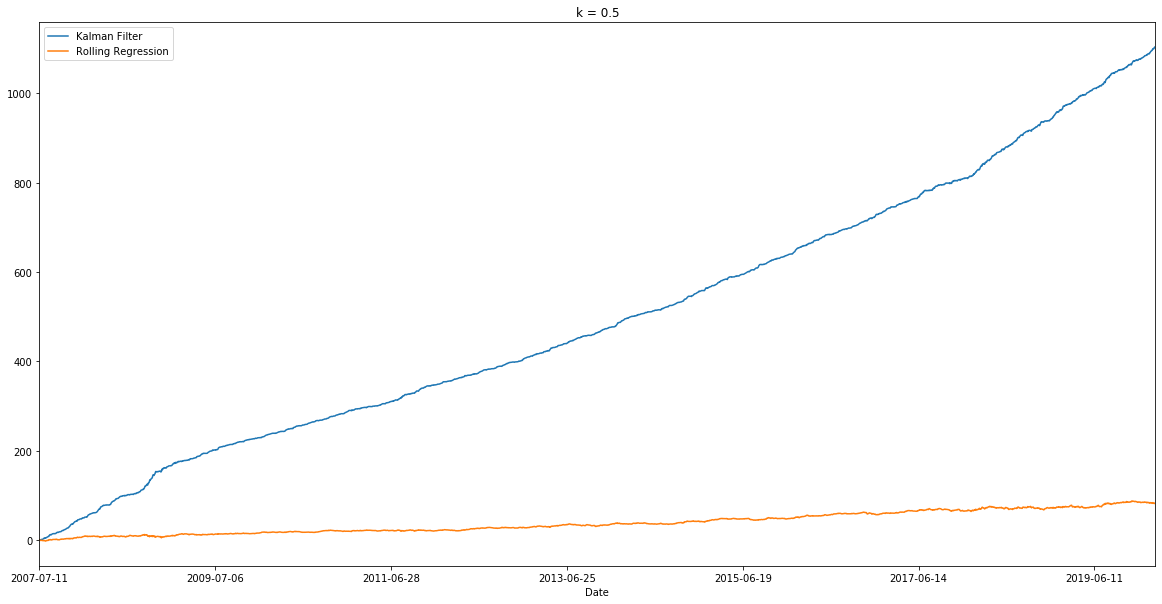

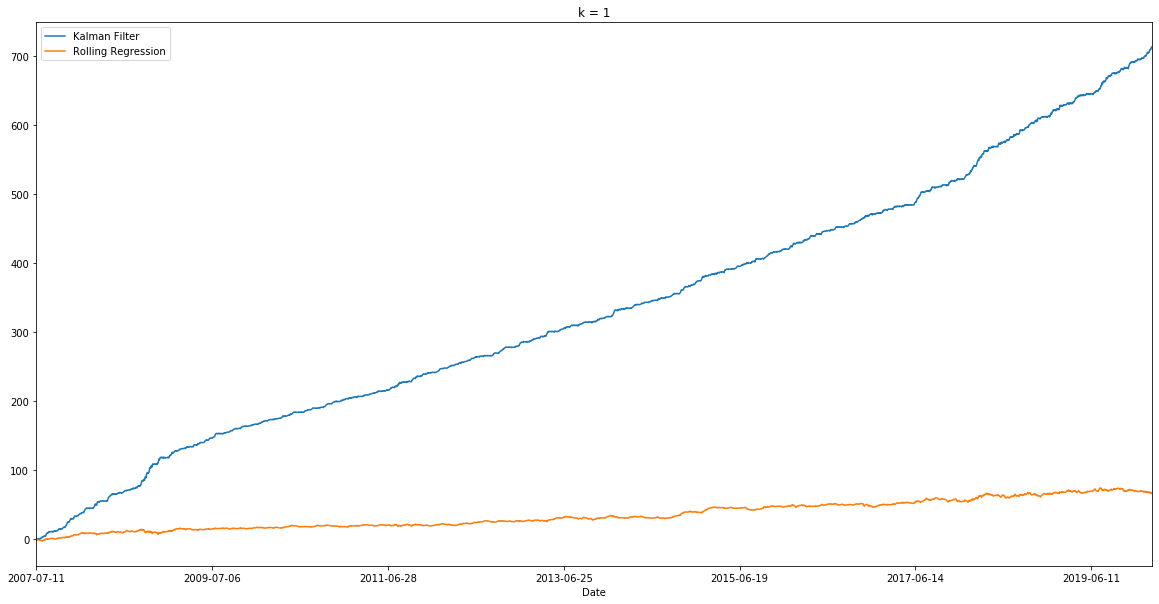

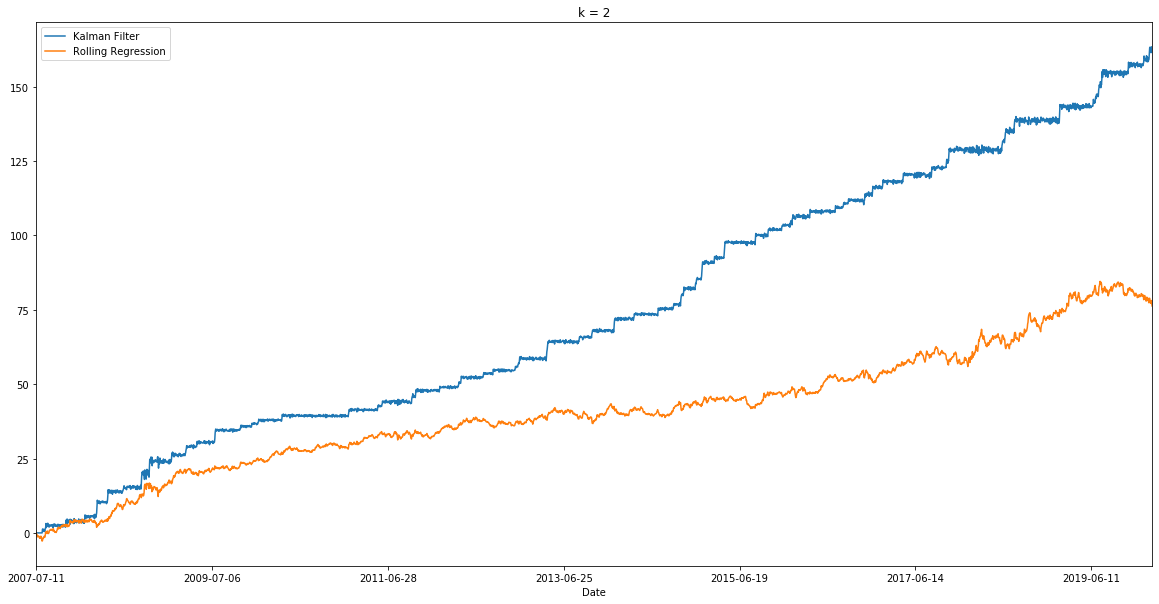

In [226]:
kalman_position_1, kalman_perform_1 = trade(residuals_kalman, sd_kalman, 0.5)
roll_position_1, roll_perform_1 = trade(residuals_rolling, sd_rolling, 0.5)
perform_1 = pd.concat([kalman_perform_1, roll_perform_1], axis=1)
perform_1.index = residuals.index
perform_1.columns = ['Kalman Filter', 'Rolling Regression']

kalman_position_2, kalman_perform_2 = trade(residuals_kalman, sd_kalman, 1)
roll_position_2, roll_perform_2 = trade(residuals_rolling, sd_rolling, 1)
perform_2 = pd.concat([kalman_perform_2, roll_perform_2], axis=1)
perform_2.index = residuals.index
perform_2.columns = ['Kalman Filter', 'Rolling Regression']

kalman_position_3, kalman_perform_3 = trade(residuals_kalman, sd_kalman, 2)
roll_position_3, roll_perform_3 = trade(residuals_rolling, sd_rolling, 2)
perform_3 = pd.concat([kalman_perform_3, roll_perform_3], axis=1)
perform_3.index = residuals.index
perform_3.columns = ['Kalman Filter', 'Rolling Regression']

perform_1.plot(figsize=(20, 10), title='k = 0.5')
perform_2.plot(figsize=(20, 10), title='k = 1')
perform_3.plot(figsize=(20, 10), title='k = 2')

We can see that the portfolio achieves the higher gains in case of Kalman Filter than in case of rolling regression in all three scenarios (k = 0.5, k = 1, k = 2). Let us now check how they compare against each other in terms of their Sharpe Ratios. Since there is no given risk-free rate, we assume it to be zero. With that assumption, we define the Sharpe Ratio and then calculate it for the three scenarios (k = 0.5, k = 1, k = 2). A dataframe of the comparison is then created and displayed.

In [227]:
def sharpe_ratio(data):
    ratio = (data.mean() / data.std())
    return ratio

d_kalman = {'k = 0.5':sharpe_ratio(perform_1[['Kalman Filter']]), 
            'k = 1':sharpe_ratio(perform_2[['Kalman Filter']]), 
            'k = 2':sharpe_ratio(perform_3[['Kalman Filter']])}
d_roll = {'k = 0.5':sharpe_ratio(perform_1[['Rolling Regression']]), 
            'k = 1':sharpe_ratio(perform_2[['Rolling Regression']]), 
            'k = 2':sharpe_ratio(perform_3[['Rolling Regression']])}

sharpe_ratio_kalman = pd.DataFrame(d_kalman)
sharpe_ratio_kalman.index = ['Kalman Filter']
sharpe_ratio_roll = pd.DataFrame(d_roll)
sharpe_ratio_roll.index = ['Rolling Regression']
sharpe_ratios = pd.concat([sharpe_ratio_kalman, sharpe_ratio_roll], axis=0)
sharpe_ratios

,k = 0.5,k = 1,k = 2
Kalman Filter,1.727388,1.825085,1.698726
Rolling Regression,1.597648,1.735311,2.015910


The dataframe of the Sharpe Ratios shows that when k = 0.5 and k = 1, the Kalman Filter technique for beta estimation yields a higher Sharpe Ratio than rolling regression does. However, in case of k = 2, the rolling regression technique yields a higher Sharpe Ratio.